In [14]:
import pandas as pd

pce_yoy = pd.read_csv('./data/korea_pce_monthly_yoy.csv', index_col=0, parse_dates=True)['2000-12-31':'2020-12-31']
WTI_yoy = pd.read_csv('./data/WTI_yoy.csv', index_col=0, parse_dates=True)['2000-12-31':'2020-12-31']

In [15]:
pce_yoy

,1
2001-01-01,3.4
2001-02-01,3.6
2001-03-01,4.0
2001-04-01,4.8
2001-05-01,5.3
...,...
2020-08-01,0.8
2020-09-01,0.9
2020-10-01,0.1
2020-11-01,0.6


<Axes: >

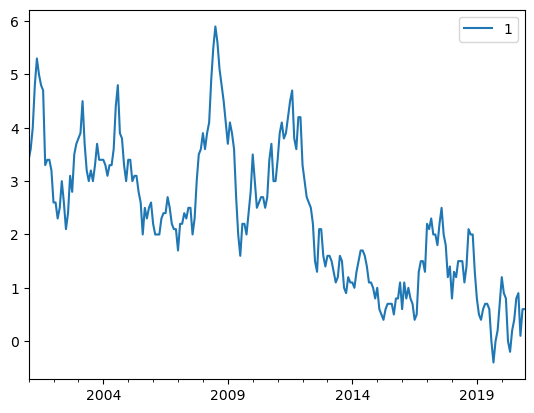

In [16]:
pce_yoy.plot()

<Axes: xlabel='Date'>

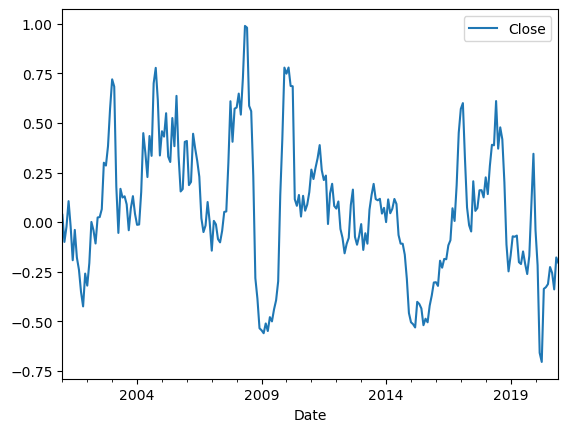

In [17]:
WTI_yoy.plot()

In [18]:
WTI_yoy = WTI_yoy.reindex(pce_yoy.index)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 38 seconds.


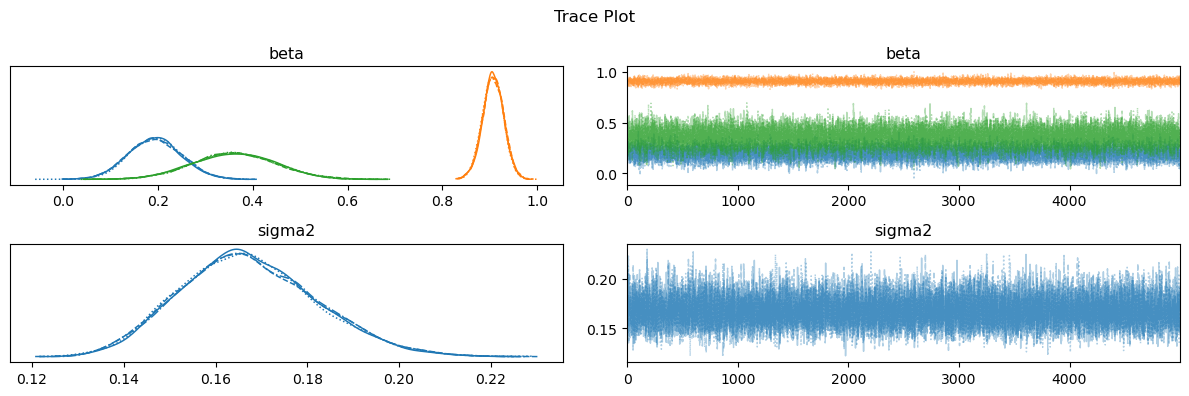

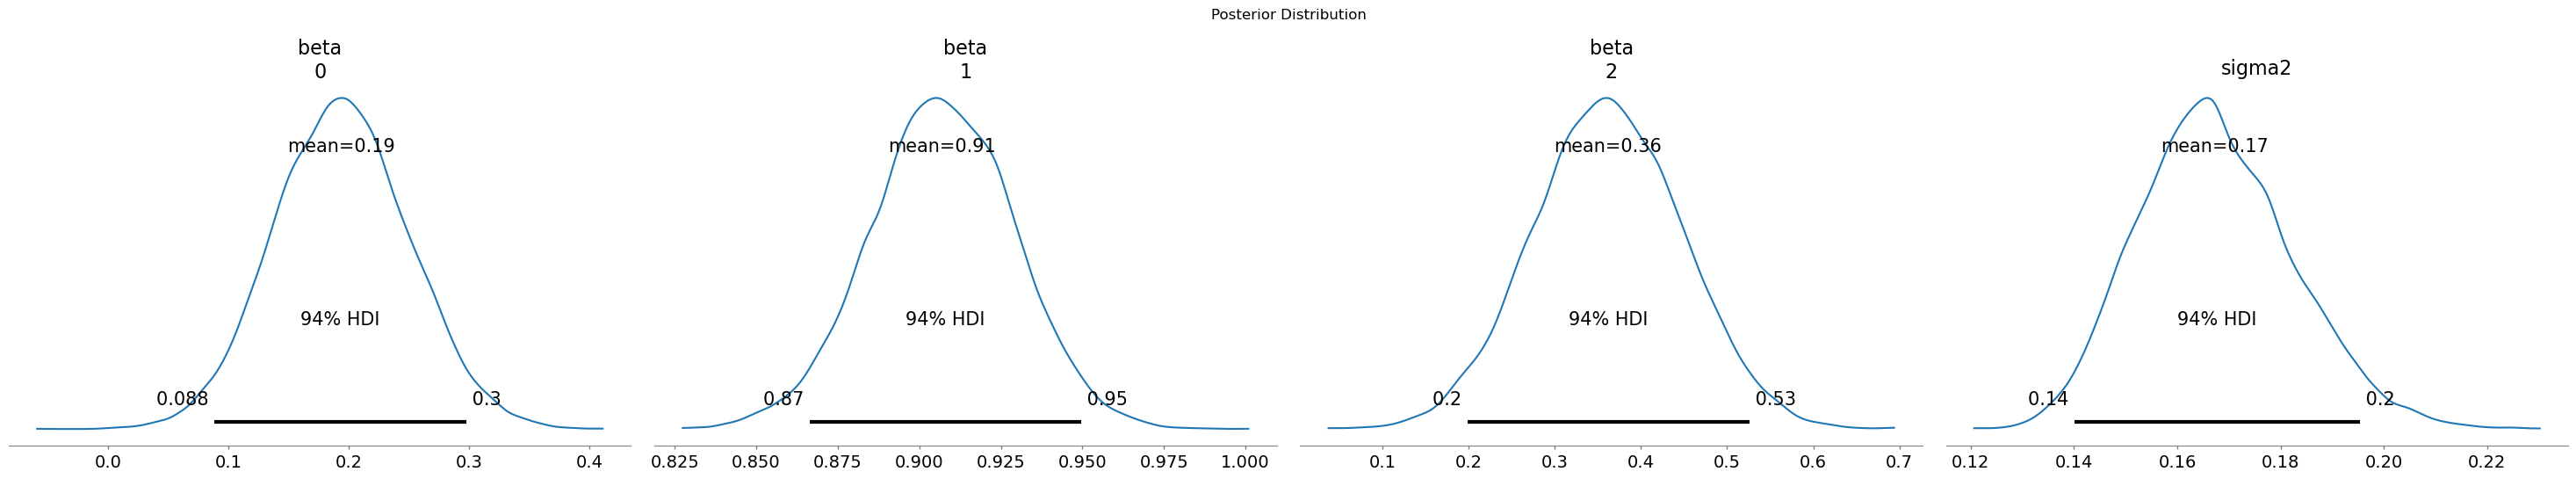

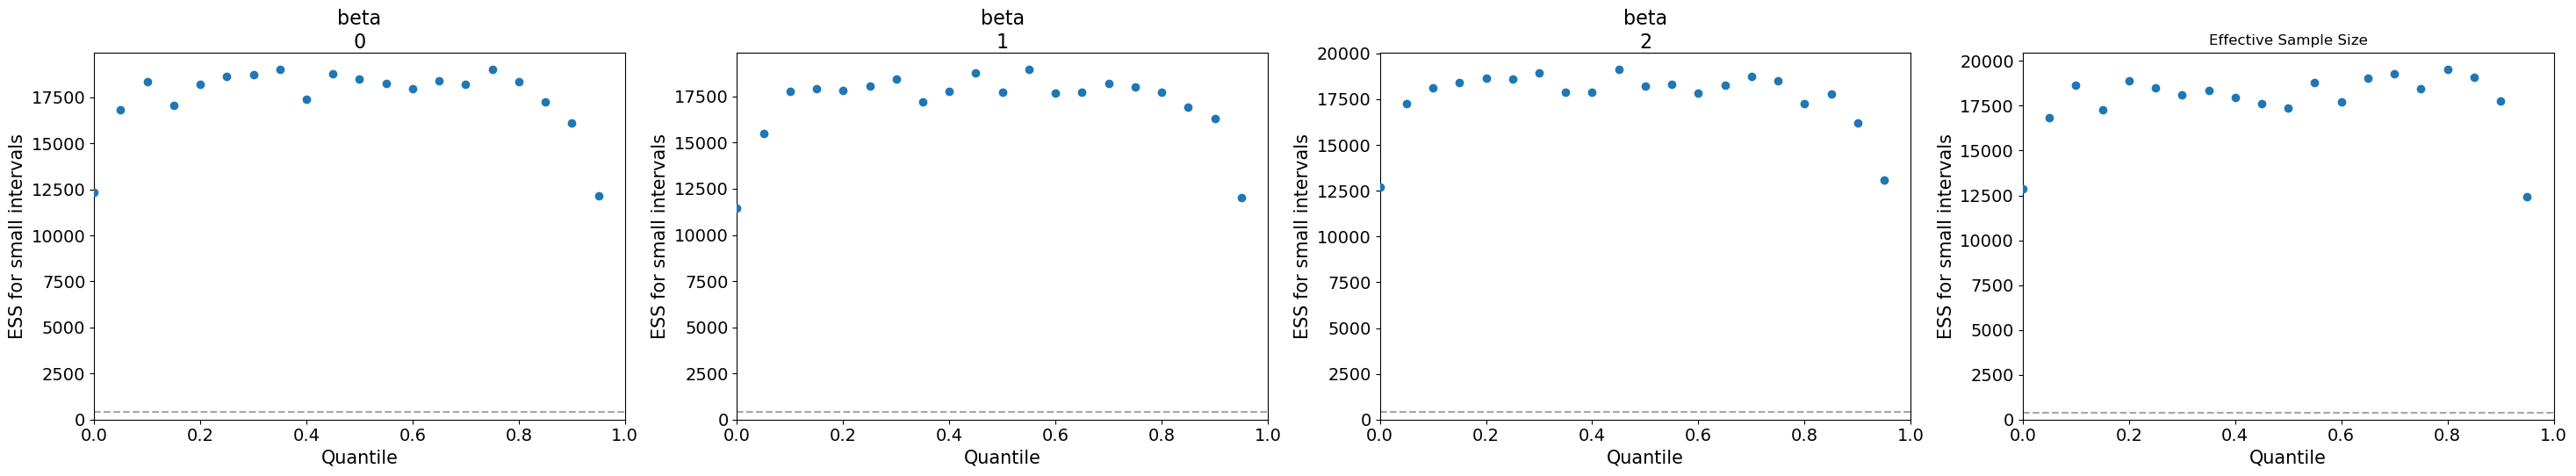

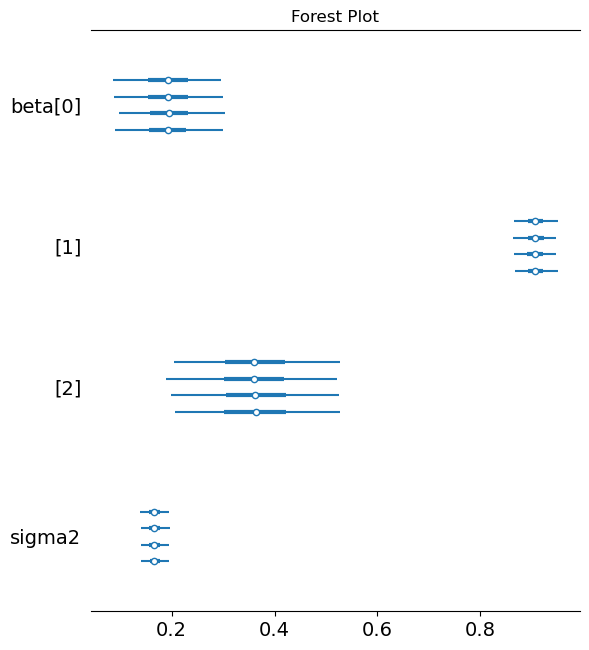

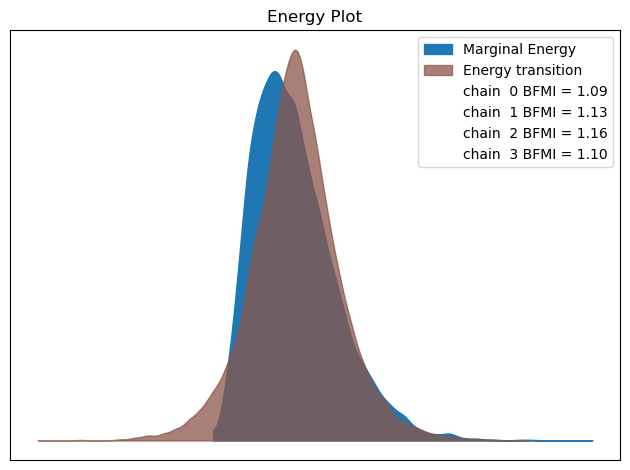

Summary Statistics:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  0.194  0.056   0.088    0.298      0.001    0.000   10484.0   
beta[1]  0.907  0.022   0.866    0.950      0.000    0.000   10016.0   
beta[2]  0.362  0.087   0.199    0.526      0.001    0.001   12967.0   
sigma2   0.167  0.015   0.140    0.195      0.000    0.000   17419.0   

         ess_tail  r_hat  
beta[0]   12149.0    1.0  
beta[1]   11462.0    1.0  
beta[2]   12721.0    1.0  
sigma2    12427.0    1.0  


In [20]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 가상 데이터 생성 또는 실제 데이터를 여기에 불러옵니다.
# 예시 데이터: 물가상승률 데이터 (y_t), 설명변수 (x_t)
# 실제 데이터는 여기에 맞게 불러옵니다.

y = pce_yoy.values  # 물가상승률 데이터 (대체)
x = WTI_yoy.values # 설명 변수 데이터

# PyMC 모델 시작
with pm.Model() as model:

    # 파라미터 설정: c, ϕ, ρ
    beta_prior = pm.MvNormal(
        'beta', 
        mu=np.array([0.5, 0.5, 0]), 
        cov=0.25 * np.eye(3), 
        shape=3
    )
    c_prior   = beta_prior[0]
    phi_prior = beta_prior[1]
    rho_prior = beta_prior[2]

    # 시그마^2 (σ^2)의 InverseGamma 분포
    sigma2_prior = pm.InverseGamma('sigma2', alpha=10, beta=2)

    # 선형 회귀식: y_t = c + ϕ * y_t-1 + ρ * x_t + σ
    mu = c_prior + phi_prior * np.roll(y, 1) + rho_prior * np.roll(x, 1)

    # 관측된 데이터의 likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=np.sqrt(sigma2_prior), observed=y)

    # 샘플링
    trace = pm.sample(5000, return_inferencedata=True)

# 1. 트레이스 플롯
az.plot_trace(trace)
plt.suptitle("Trace Plot")
plt.tight_layout()
plt.show()
az.plot_posterior(trace)
plt.suptitle("Posterior Distribution")
plt.tight_layout()
plt.show()
az.plot_ess(trace)
plt.title("Effective Sample Size")
plt.tight_layout()
plt.show()
az.plot_forest(trace)
plt.title("Forest Plot")
plt.tight_layout()
plt.show()
az.plot_energy(trace)
plt.title("Energy Plot")
plt.tight_layout()
plt.show()
summary = az.summary(trace)
print("Summary Statistics:")
print(summary)